In [117]:

import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt


In [118]:
df = pd.read_csv('data\\UTKFaceAugmented.csv')

# Split Dataframe to Input and Target Features 
## Chose to be a Regression Task (Target = age)

In [119]:
print(df.columns)
print(df.head())
target = df['age']
features = df.drop(['age', 'age_range'], axis=1)
print(df.columns)

Index(['Unnamed: 0', 'filename', 'age', 'gender', 'race', 'age_range',
       'num_haircuts_life', 'has_tiktok', 'remembers_disco', 'uses_skincare',
       'max_annual_earnings'],
      dtype='object')
   Unnamed: 0                                filename  age  gender   race  \
0           0  100_0_0_20170112213500903.jpg.chip.jpg  100    male  white   
1           1  100_0_0_20170112215240346.jpg.chip.jpg  100    male  white   
2           2  100_1_0_20170110183726390.jpg.chip.jpg  100  female  white   
3           3  100_1_0_20170112213001988.jpg.chip.jpg  100  female  white   
4           4  100_1_0_20170112213303693.jpg.chip.jpg  100  female  white   

  age_range  num_haircuts_life has_tiktok remembers_disco uses_skincare  \
0   100-119                360         no              no            no   
1   100-119                627         no              no            no   
2   100-119                687         no             yes            no   
3   100-119                710     

# Visualizing the Data

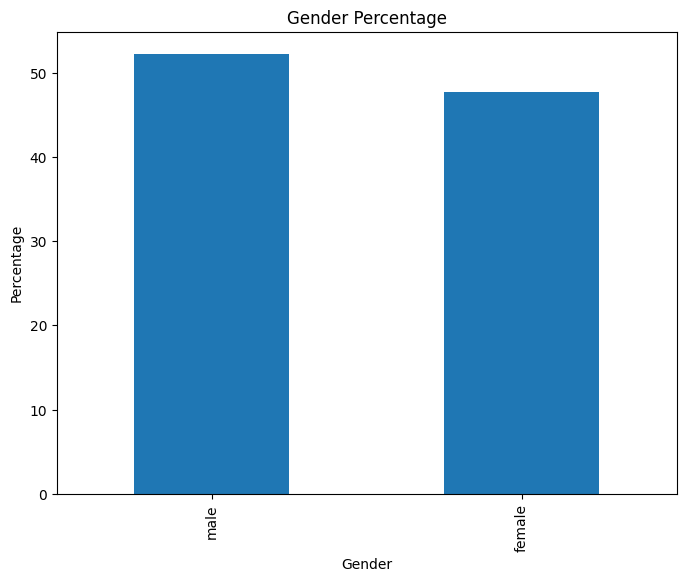

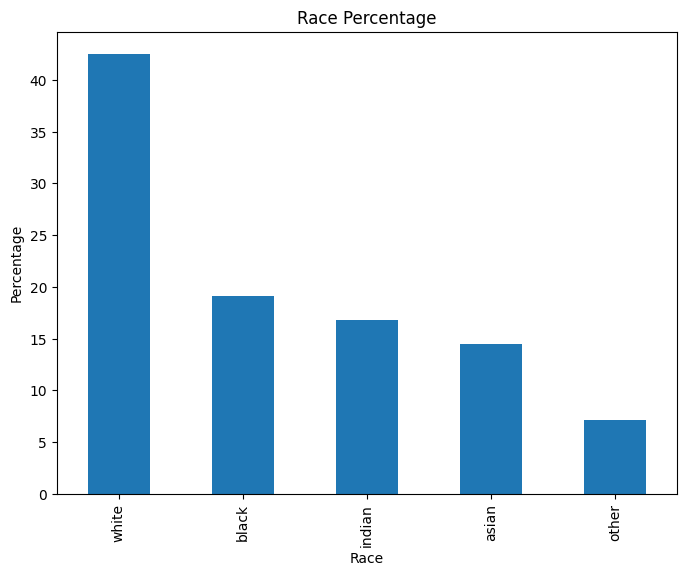

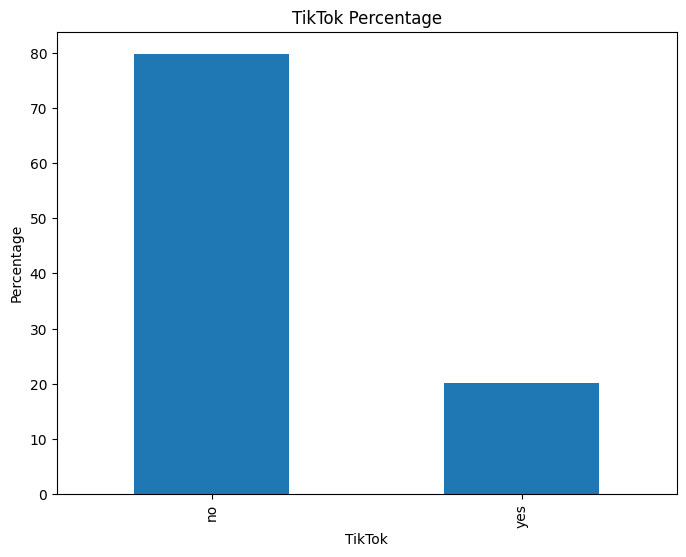

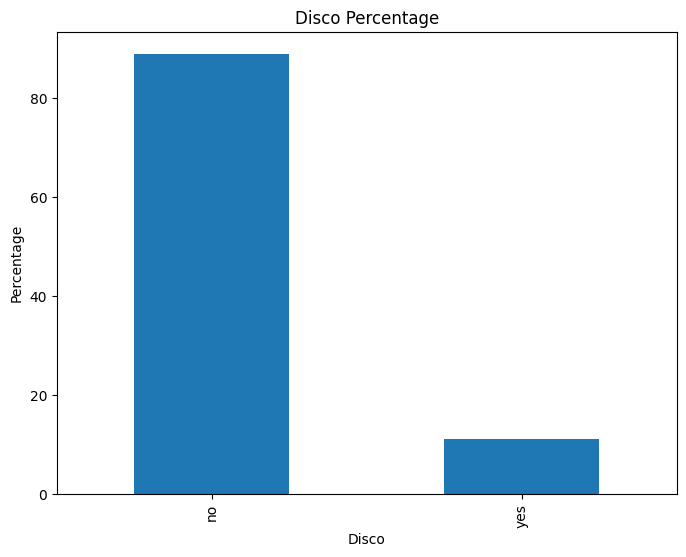

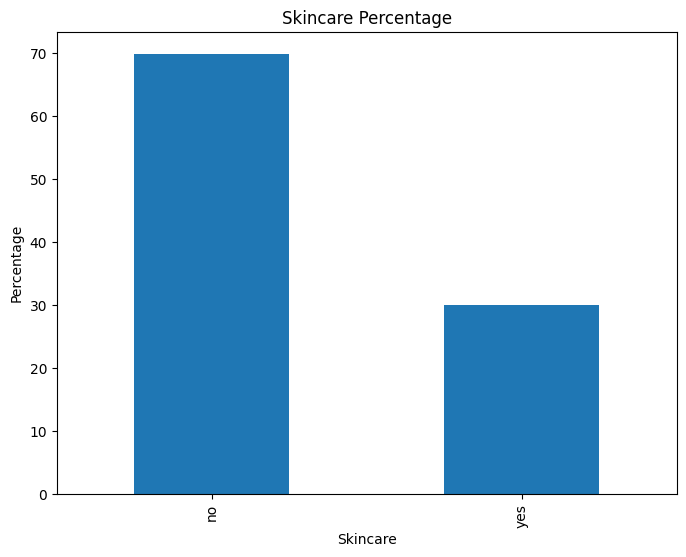

In [120]:
gender_perc = df['gender'].value_counts()/len(df)*100
race_perc = df['race'].value_counts()/len(df)*100
tiktok_perc = df['has_tiktok'].value_counts()/len(df)*100
disco_perc = df['remembers_disco'].value_counts()/len(df)*100
skincar_perc = df['uses_skincare'].value_counts()/len(df)*100

gender_perc = gender_perc.round(2)
race_perc = race_perc.round(2)
tiktok_perc = tiktok_perc.round(2)
disco_perc = disco_perc.round(2)
skincar_perc = skincar_perc.round(2)

# Plot gender percentage
gender_perc.plot(kind='bar', figsize=(8, 6))
plt.title('Gender Percentage')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.show()

# Plot race percentage
race_perc.plot(kind='bar', figsize=(8, 6))
plt.title('Race Percentage')
plt.xlabel('Race')
plt.ylabel('Percentage')
plt.show()

# Plot TikTok percentage
tiktok_perc.plot(kind='bar', figsize=(8, 6))
plt.title('TikTok Percentage')
plt.xlabel('TikTok')
plt.ylabel('Percentage')
plt.show()

# Plot disco percentage
disco_perc.plot(kind='bar', figsize=(8, 6))
plt.title('Disco Percentage')
plt.xlabel('Disco')
plt.ylabel('Percentage')
plt.show()

# Plot skincare percentage
skincar_perc.plot(kind='bar', figsize=(8, 6))
plt.title('Skincare Percentage')
plt.xlabel('Skincare')
plt.ylabel('Percentage')
plt.show()


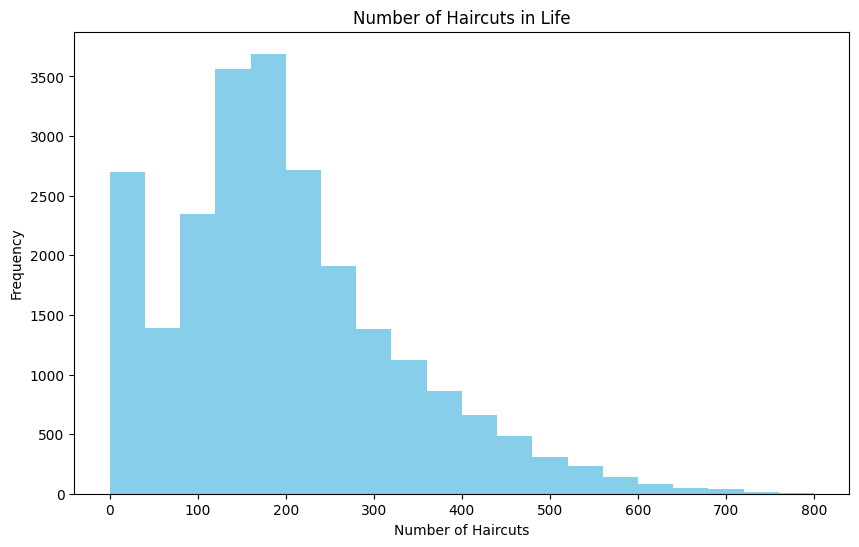

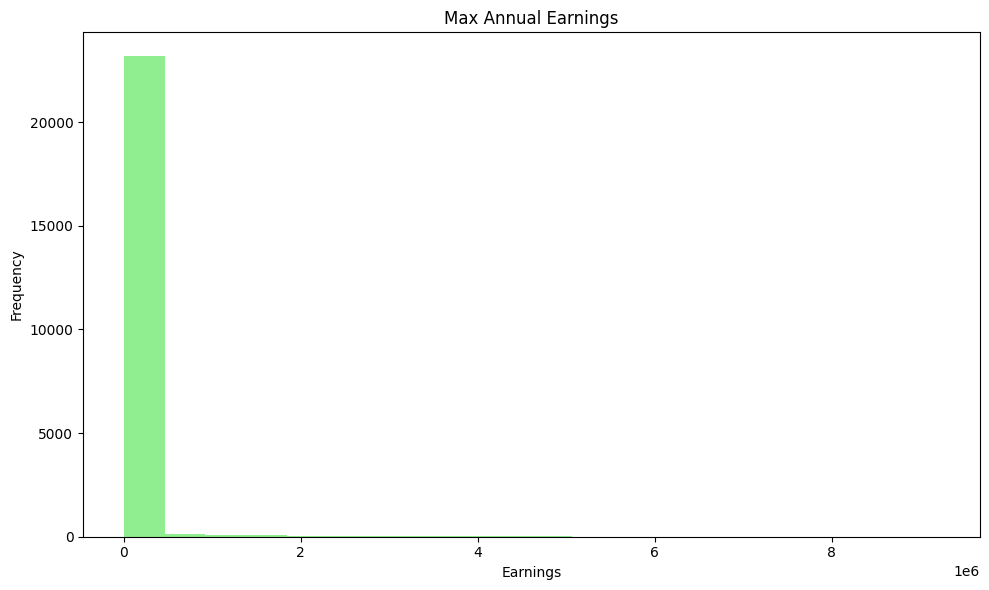

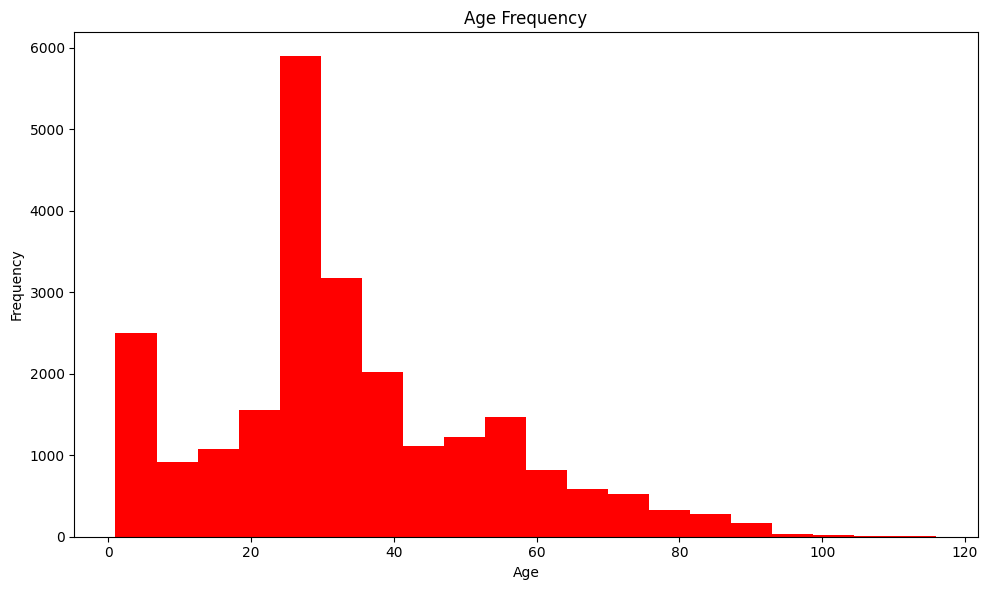

In [121]:
plt.figure(figsize=(10, 6))

# Plot histogram for num_haircuts_life
plt.hist(df['num_haircuts_life'], bins=20, color='skyblue')
plt.title('Number of Haircuts in Life')
plt.xlabel('Number of Haircuts')
plt.ylabel('Frequency')

# Plot histogram for max_annual_earnings
plt.figure(figsize=(10, 6))
plt.hist(df['max_annual_earnings'], bins=20, color='lightgreen')
plt.title('Max Annual Earnings')
plt.xlabel('Earnings')
plt.ylabel('Frequency')
plt.tight_layout()

# Plot histogram for age
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=20, color='red')
plt.title('Age Frequency')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()

plt.show()


# Data Preprocessing for Model 1 - Linear Regression Model #

In [122]:
#Selecting potentially relevant features
cm_features = ['gender', 'race', 'num_haircuts_life', 'has_tiktok', 'uses_skincare']
cm_df = df[cm_features]

print(cm_df.head())

   gender   race  num_haircuts_life has_tiktok uses_skincare
0    male  white                360         no            no
1    male  white                627         no            no
2  female  white                687         no            no
3  female  white                710         no            no
4  female  white                614         no            no


#### One-Hot Encode Categorical Features

In [123]:
categorical_features = ['gender', 'race', 'has_tiktok', 'uses_skincare']

print('Categorical Features')
for feature in categorical_features:
    print(feature)
    print(cm_df[feature].unique())

Categorical Features
gender
['male' 'female']
race
['white' 'asian' 'black' 'indian' 'other']
has_tiktok
['no' 'yes']
uses_skincare
['no' 'yes']


#### Convert 2-state classification columns to binary ints

In [124]:
cm_df.loc[:, 'has_tiktok'] = cm_df['has_tiktok'].map({'no': 0, 'yes': 1})
cm_df.loc[:, 'uses_skincare'] = cm_df['uses_skincare'].map({'no': 0, 'yes': 1})

#### Convert the rest of the multi-state categorical columns to one hot encoding 

In [125]:

multi_categorical_columns = ['race', 'gender']
cm_df = pd.get_dummies(cm_df, columns=multi_categorical_columns)
#To maintain snake_case naming convention
cm_df.columns = cm_df.columns.str.replace('-', '_')


#### Ensure all feature datatypes are integers now

In [126]:

for features in cm_df.columns:
    if (cm_df[features].dtype == bool) or (cm_df[features].dtype == object):
        cm_df[features] = cm_df[features].astype(int)

print('\nDataframe after conversion preprocessing and one hot encoding')
print(cm_df.dtypes)



Dataframe after conversion preprocessing and one hot encoding
num_haircuts_life    int64
has_tiktok           int32
uses_skincare        int32
race_asian           int32
race_black           int32
race_indian          int32
race_other           int32
race_white           int32
gender_female        int32
gender_male          int32
dtype: object


#### Check for missing values in the dataset, incase NaN needs to be dropped or interpolated

In [127]:
print(cm_df.isna().sum())

num_haircuts_life    0
has_tiktok           0
uses_skincare        0
race_asian           0
race_black           0
race_indian          0
race_other           0
race_white           0
gender_female        0
gender_male          0
dtype: int64


#### Initialize Bias Column (Y-intercept) for Linear Regression Model

In [128]:
cm_df['bias'] = 1

### Divide Linear Regression Data into Train, Validation, Test Set data 

In [129]:
#Dont stratify because its a regression problem
cm_x_train, cm_x_check, cm_y_train, cm_y_check = train_test_split(cm_df, target, test_size=0.2, random_state=42, stratify=cm_df['has_tiktok'])
cm_x_val, cm_x_test, cm_y_val, cm_y_test = train_test_split(cm_x_check, cm_y_check, test_size=0.5, random_state=42, stratify=cm_x_check['has_tiktok'])


#### Apply Standardization to Continuous Numerical Data (No single feature dominates the learning process due to having a larger scale than others)

In [130]:
scaler = StandardScaler()
columns_to_scale = ['num_haircuts_life']
cm_x_train[columns_to_scale] = scaler.fit_transform(cm_x_train[columns_to_scale])
cm_x_val[columns_to_scale] = scaler.transform(cm_x_val[columns_to_scale])
cm_x_test[columns_to_scale] = scaler.transform(cm_x_test[columns_to_scale])

print(cm_x_train.head())



       num_haircuts_life  has_tiktok  uses_skincare  race_asian  race_black  \
15343           0.432937           0              1           0           0   
7511           -0.585755           0              0           1           0   
19070           0.128850           0              0           0           0   
21734          -1.376382           0              0           0           0   
10280          -1.460006           0              0           0           0   

       race_indian  race_other  race_white  gender_female  gender_male  bias  
15343            0           0           1              0            1     1  
7511             0           0           0              1            0     1  
19070            1           0           0              0            1     1  
21734            0           0           1              1            0     1  
10280            0           0           1              1            0     1  


#### Store Train, Val, and Test Sets

In [131]:
#Save the data for use in the regression model
cm_x_train = cm_x_train.to_numpy()
cm_x_test = cm_x_test.to_numpy()
cm_y_train = cm_y_train.to_numpy()
cm_y_test = cm_y_test.to_numpy()
cm_x_val = cm_x_val.to_numpy()
cm_y_val = cm_y_val.to_numpy()

directory = 'tensor_collection'
os.makedirs(directory, exist_ok=True)

torch.save(cm_x_train, directory + '/lr_x_train.pt')
torch.save(cm_x_test, directory + '/lr_x_test.pt')
torch.save(cm_y_train, directory + '/lr_y_train.pt')
torch.save(cm_y_test, directory + '/lr_y_test.pt')
torch.save(cm_x_val, directory + '/lr_x_val.pt')
torch.save(cm_y_val, directory + '/lr_y_val.pt')

# Data Preprocessing for Model 2 - Convolutional Neural Network
### AND
# Data Preprocessing for Model 3 - Multi Modela Neural Network

In [132]:
nn_df = cm_df
nn_df.drop(['bias'], axis=1, inplace=True)
print(nn_df.head())

   num_haircuts_life  has_tiktok  uses_skincare  race_asian  race_black  \
0                360           0              0           0           0   
1                627           0              0           0           0   
2                687           0              0           0           0   
3                710           0              0           0           0   
4                614           0              0           0           0   

   race_indian  race_other  race_white  gender_female  gender_male  
0            0           0           1              0            1  
1            0           0           1              0            1  
2            0           0           1              1            0  
3            0           0           1              1            0  
4            0           0           1              1            0  


In [133]:

in_directory = 'data\\images'

nn_df['filename'] = in_directory + '\\' + df['filename'].astype(str)


print(nn_df.head())

   num_haircuts_life  has_tiktok  uses_skincare  race_asian  race_black  \
0                360           0              0           0           0   
1                627           0              0           0           0   
2                687           0              0           0           0   
3                710           0              0           0           0   
4                614           0              0           0           0   

   race_indian  race_other  race_white  gender_female  gender_male  \
0            0           0           1              0            1   
1            0           0           1              0            1   
2            0           0           1              1            0   
3            0           0           1              1            0   
4            0           0           1              1            0   

                                            filename  
0  data\images\100_0_0_20170112213500903.jpg.chip...  
1  data\images\100

#### Divide data into train, val, test datasets

In [134]:
nn_x_train, nn_x_check, nn_age_train, nn_age_check = train_test_split(nn_df, target, test_size=0.2, random_state=42, stratify=nn_df['has_tiktok'])
nn_x_val, nn_x_test, nn_age_val, nn_age_test = train_test_split(nn_x_check, nn_age_check, test_size=0.5, random_state=42, stratify=nn_x_check['has_tiktok'])

In [135]:

#store the train test validation as csv as it only stores filename (String)
nn_x_train['filename'].to_csv(directory + '/cnn_x_train.csv', index=False)
nn_x_test['filename'].to_csv(directory + '/cnn_x_test.csv', index=False)
nn_x_val['filename'].to_csv(directory + '/cnn_x_val.csv', index=False)

#convert all age to torch tensors as its only numerical
nn_age_train = nn_age_train.to_numpy()
nn_age_test = nn_age_test.to_numpy()
nn_age_val = nn_age_val.to_numpy()

torch.save(nn_age_train, directory + '/cnn_y_train.pt')
torch.save(nn_age_test, directory + '/cnn_y_test.pt')
torch.save(nn_age_val, directory + '/cnn_y_val.pt')



#### Save the Train, Val, Test Sets

In [136]:
#store the traiin test validation as csv as it stores filename (String)
nn_x_train.to_csv(directory + '/mmnn_x_train.csv', index=False)
nn_x_test.to_csv(directory + '/mmnn_x_test.csv', index=False)
nn_x_val.to_csv(directory + '/mmnn_x_val.csv', index=False)

#convert all age to torch tensors as its only numerical
torch.save(nn_age_train, directory + '/mmnn_y_train.pt')
torch.save(nn_age_test, directory + '/mmnn_y_test.pt')
torch.save(nn_age_val, directory + '/mmnn_y_val.pt')

